# Preferential Bayesian Optimization: Predictive Entropy Search
This notebook demonstrates the use of the Predictive Entropy Search (PES) acquisition function on ordinal (preference) data, and compares its performance directly to the Dueling-Thompson sampling acquisition function by Gonzalez et al (2017). 

We conduct experiments over simple 1-dimensional values in the domain [0, 1] and define the following preference ordering over them: given the Forrester function f (1-dimensional test function by Forrester et al. (2008)), and two inputs a and b, a > b if f(a) < f(b).

Formulation by Nguyen Quoc Phong.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

In [2]:
sys.path.append(os.path.split(os.path.split(os.getcwd())[0])[0]) # Move 2 levels up directory to import PBO
import PBO

In [3]:
def forrester(x):
    """
    1-dimensional test function by Forrester et al. (2008)
    Defined as f(x) = (6x-2)^2 * sin(12x-4)
    :param x: float in domain [0, 1]
    """
    return (6*x-2)*(6*x-2)*np.sin(12*x-4)

def forrester_get_y(X):
    """
    Returns np array of shape (num_data, 1), indicating the input value with the most preferred Forrester value
    (lower is better)
    param X: np array of shape (num_data, num_choices, 1)
    """
    
    forr_vals = np.argmin(forrester(X), axis=1)
    return np.squeeze(np.take_along_axis(X, np.expand_dims(forr_vals, axis=2), axis=1), axis=2)

In [4]:
def plot_gp(model, X, y, title):
    #Plotting code from GPflow authors

    ## generate test points for prediction
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

    ## predict mean and variance of latent GP at test points
    mean, var = model.predict_f(xx)

    ## generate 10 samples from posterior
    samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

    ## plot 
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

    plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
    plt.xlim(-0.1, 1.1)
    plt.title(title)

## 1.  Learning from ordinal data

In [5]:
# Sample data
X = np.array([[[0.2], [0.4]],
              [[0.4], [0.7]],
              [[0.76], [0.9]],
              [[0.9], [0.2]],
              [[0.7], [0.9]],
              [[0.2], [0.7]],
              [[0.7], [0.76]]])
y = forrester_get_y(X)

Learn variational parameters for each input seen in training data:

In [6]:
q_mu, q_var, inputs = PBO.models.learning.train_model(X, y, num_steps=3000)

Negative ELBO at step 0: 8.343536545924373
Negative ELBO at step 500: 5.911234767469275
Negative ELBO at step 1000: 5.546304462511973
Negative ELBO at step 1500: 5.529717857067619
Negative ELBO at step 2000: 5.5288978664207065
Negative ELBO at step 2500: 5.528874521824841


Create sparse variational Gaussian process model using these parameters:

In [7]:
kernel = gpflow.kernels.RBF()
likelihood = gpflow.likelihoods.Gaussian()
model = PBO.models.learning.init_SVGP(q_mu, q_var, inputs, kernel, likelihood)

In [8]:
# Tune hyperparameters. TODO: Find automatic way to do this
model.kernel.lengthscale.assign(0.07)

In [9]:
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.lengthscale,Parameter,Softplus,,True,(),float64,0.07000000029802327
SVGP.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(5, 1)",float64,[[0.2...
SVGP.q_mu,Parameter,,,False,"(5, 1)",float64,[[0.20238954...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 5, 5)",float64,"[[[0.59786945, 0., 0...."


Visualize the model so far:

In [10]:
func_evals = np.expand_dims(q_mu.numpy(),1)

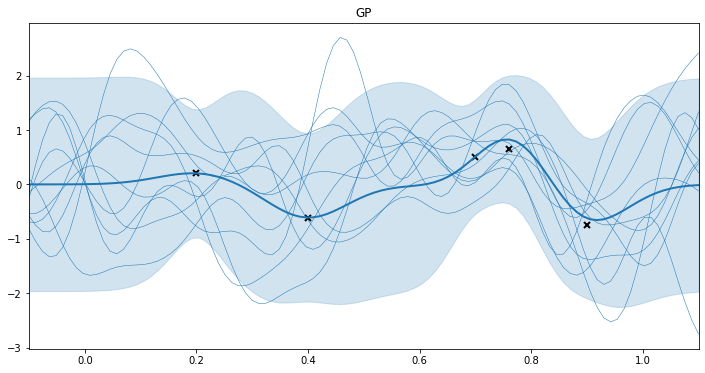

In [11]:
plot_gp(model, inputs, func_evals, "GP")

## 2. Predictive Entropy Search

In [12]:
num_runs = 10
num_evals = 20
num_samples = 100
num_choices = 2
input_dims = 1
num_maximizers = 20
num_init_points = 5

The following function captures what was done in the previous section, as we need to retrain the model after every evaluation.

In [13]:
def train_and_visualize(X, y, title):
    
    # Train model with data
    q_mu, q_var, inputs = PBO.models.learning.train_model(X, y, num_steps=3000)
    kernel = gpflow.kernels.RBF()
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP(q_mu, q_var, inputs, kernel, likelihood)
    model.kernel.lengthscale.assign(0.07)
    func_evals = np.expand_dims(q_mu.numpy(),1)
    
    # Visualize model
    plot_gp(model, inputs, func_evals, title)
    
    return model, inputs, func_evals

This function is our main metric for the performance of the acquisition function: The closer the model's best guess to the target (in this case, the global minimum of the Forrester function), the better.

In [14]:
def best_guess(model):
    """
    Returns a GP model's best guess of the global maximum of f.
    """
    xx = np.linspace(0.0, 1.0, 10000000).reshape(10000000, 1)
    res = model.predict_f(xx)[0].numpy()
    return xx[np.argmax(res)]

Store the results in these arrays:

In [15]:
num_data_at_end = int((num_init_points-1) * num_init_points / 2 + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, 1])
best_guess_results = np.zeros([num_runs, num_evals, input_dims])

Create the initial values for each run:

In [16]:
np.random.seed(0)
init_points = np.random.uniform(size=[num_runs, num_init_points, input_dims])
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.

Beginning run 0
Negative ELBO at step 0: 11.920477584342475
Negative ELBO at step 500: 8.2780474711761
Negative ELBO at step 1000: 7.414828791194752
Negative ELBO at step 1500: 7.301098257993925
Negative ELBO at step 2000: 7.284799375316113
Negative ELBO at step 2500: 7.283619050200412
Beginning evaluation 0
Evaluation 0: Sampling maximizers
Evaluation 0: Calculating I
Evaluation 0: Next query is [[0.60276338]
 [0.94466892]] with I value of 0.08464730182756662
Negative ELBO at step 0: 13.112126021305436
Negative ELBO at step 500: 9.029084585835868
Negative ELBO at step 1000: 8.037274625159741
Negative ELBO at step 1500: 7.914679683503883
Negative ELBO at step 2000: 7.897287188312445
Negative ELBO at step 2500: 7.896001021407139
Beginning evaluation 1
Evaluation 1: Sampling maximizers
Evaluation 1: Calculating I
Evaluation 1: Next query is [[0.94466892]
 [0.23789282]] with I value of 0.09358062636969083
Negative ELBO at step 0: 14.3037744582792
Negative ELBO at step 500: 9.8541870008261

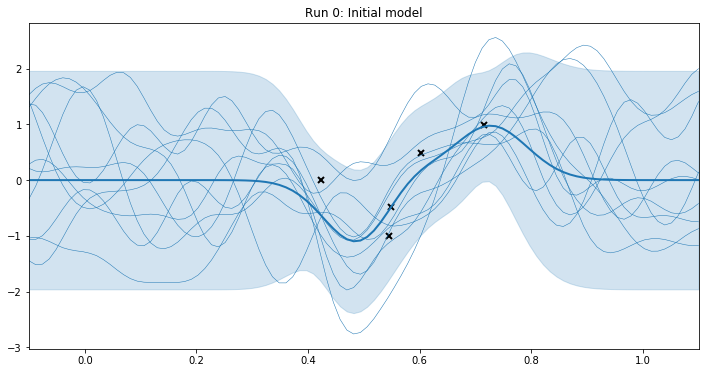

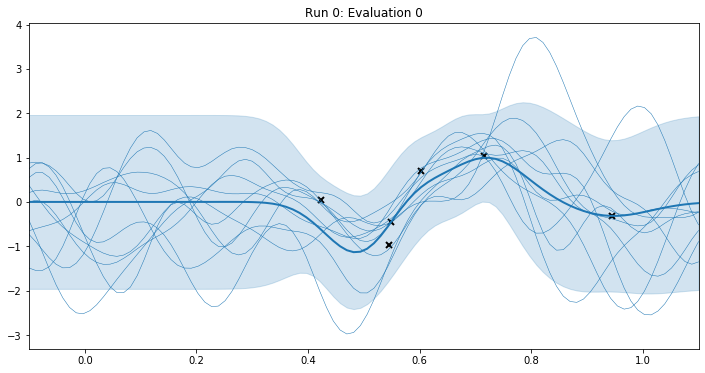

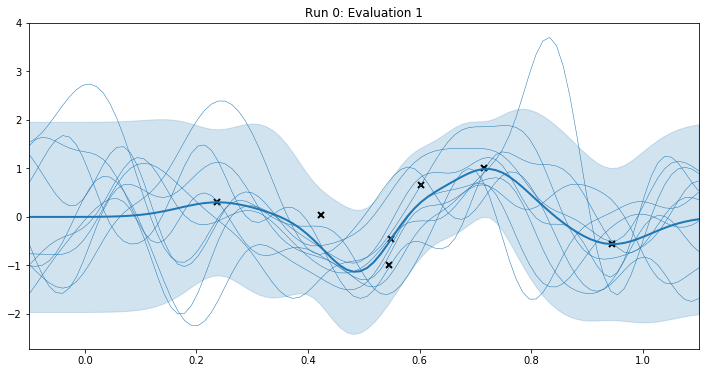

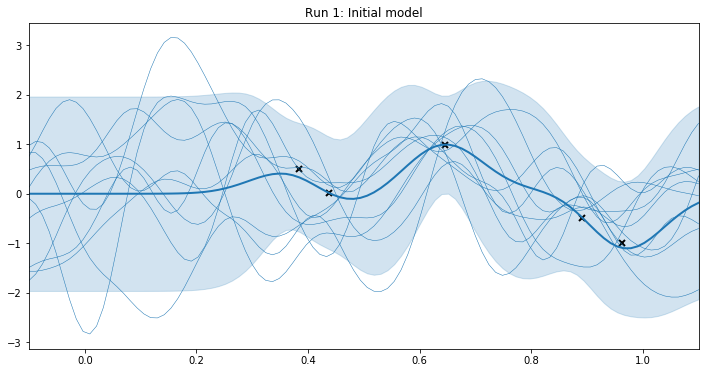

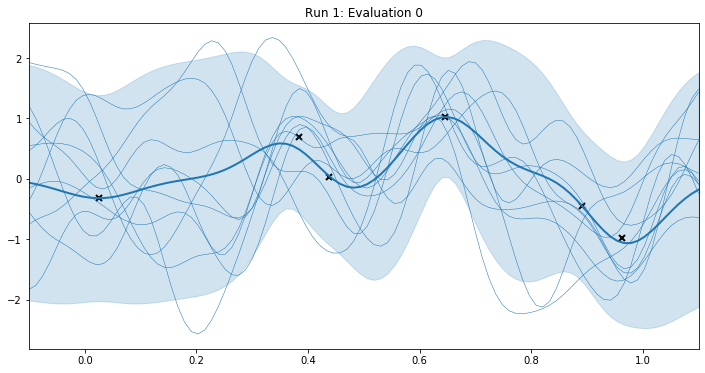

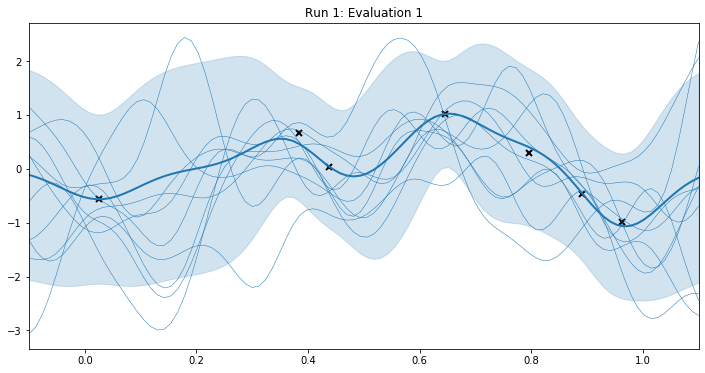

In [17]:
for run in range(num_runs):
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = forrester_get_y(X)
    
    model, inputs, func_evals = train_and_visualize(X, y, "Run {}: Initial model".format(run))

    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation)) 

        # Sample possible next queries
        
        samples = PBO.acquisitions.pes.sample_inputs(inputs, num_samples, num_choices)

        # Sample maximizers
        print("Evaluation %s: Sampling maximizers" % (evaluation))
        maximizers = PBO.acquisitions.pes.sample_maximizers(X=inputs, 
                                                            y=func_evals, 
                                                            count=num_maximizers,
                                                            D=1000,
                                                            variance=1.0)

        # Calculate PES value I for each possible next query
        print("Evaluation %s: Calculating I" % (evaluation))
        I_vals = PBO.acquisitions.pes.I_batch(samples, maximizers, model)

        # Select query that maximizes I
        next_idx = np.argmax(I_vals)
        next_query = samples[next_idx]
        print("Evaluation %s: Next query is %s with I value of %s" % (evaluation, next_query, I_vals[next_idx]))

        X = np.concatenate([X, [next_query]])
        # Evaluate objective function
        y = forrester_get_y(X)
        
        print("Evaluation %s: Training model" % (evaluation))
        model, inputs, func_evals = train_and_visualize(X, y, "Run {}: Evaluation {}".format(run, evaluation))

        best_guess_results[run, evaluation, :] = best_guess(model)

    X_results[run] = X
    y_results[run] = y